In [72]:
import time

class Pid:
    
    def __init__(self, kP=1, kI=0, kD=0, max_error=10, min_sample_time=1):
        self.kP = kP
        self.kI = kI
        self.kD = kD
        assert max_error > 0, "max_intergal_error must be greater than 0"
        self.max_integral_error = max_error
        self.min_sample_time = min_sample_time
        self.reset()

    def reset(self):
        #total error
        self.error = 0
        self.last_error = 0
        self.last_update_time = 0
        self.target = 0
        self.output = 0
        self.integral_component = 0
    
    def set_target(self, value):
        self.target = value
    
    def get_target(self):
        return self.target
    
    def get_error(self):
        return self.error
    
    def calc_proportional(self):
        return self.kP * self.error
    
    def calc_integral(self):
        self.integral_component = self.integral_component + self.error * self.dt
        if (abs(self.integral_component) > self.max_integral_error):
            sign_correction = 1 if self.integral_component > 0 else -1
            self.integral_component = sign_correction * self.integral_component
            
        return self.kI * self.integral_component
    
    def calc_differential(self):
        if (self.dt == 0):
            return 0
        else:
            return self.kD * self.last_error / self.dt

    
    def update(self, current_value):
        
        assert current_value is not None, "Invalid current_value is not valid" 
        
        self.current_value = current_value
         
        current_update_time = time.time()

        if (self.last_update_time == 0):
            self.dt = 1
        else:
            self.dt = current_update_time - self.last_update_time
            if (self.dt < 1):
                #default to 1 min sec sample time
                self.dt = self.min_sample_time
            
        self.last_update_time = current_update_time

        self.error =  self.target - self.current_value
        
        self.output = self.calc_proportional() + self.calc_integral() +  self.calc_differential()  
        
        self.last_error = self.error;
        
        return self.output
    
    def get_output_value(self):
        return self.output


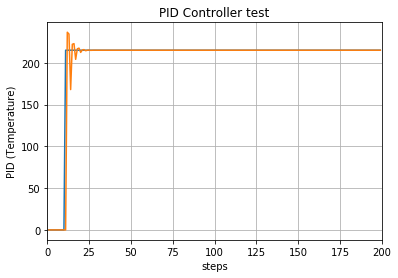

In [73]:
import matplotlib.pyplot as plt

def test_bench():
    
    def measurement(step):
        #used to mock process delay
        measurement = pid.get_output_value()
        return measurement

    pid = Pid(kP=.1, kI=1, kD=.2)
    pid.set_target(0)
    
    output_data = []
    error_data = []
    target_data = []
    steps = range(1, 200)
    feedback = 0
    for step in steps:
        pid.update(current_value=feedback)
        if (pid.get_target() > 0):
            feedback = measurement(step)
        if (step > 10):
            pid.set_target(215)
        
        error_data.append(pid.get_error())
        output_data.append(feedback)
        target_data.append(pid.get_target())
        #time delay required to simulate 1 sec sampple times in real system
        #time.sleep(1) 

    plt.plot(steps, target_data)
    plt.plot(steps, output_data)
    plt.xlim((0, 200))
    plt.xlabel('steps')
    plt.ylabel('PID (Temperature)')
    plt.title('PID Controller test')

    plt.grid(True)
    plt.show()    
    
test_bench()
